## Aliasing

In [1]:
# import packages
import numpy as np
import sounddevice as sd
import matplotlib.pyplot as plt
import time

Set some parameters.

- `fs`: Sample rate (# samples per second)
- `duration`: Duration of audio (seconds)
- `N`: number of samples

Calculate step sizes (intervals per unit).
- `dt`: time interval between each sample (seconds per sample)
- `df`: frequency interval between each second (% samples per second)

Create frequency and time vectors
- `f_arr`: frequency vector
- `t`: time vector

In [2]:
fs = 1000 # sample rate

duration = 0.35
N = int(duration * fs)

# step size
dt = 1 / fs
df = fs / N

Next, create frequency and time vectors.  

Note that we set the range of our frequency domain as the positive and frequencies up to *half* of our sample rate (`fs`).  We'll see later how this comes into play.

In [3]:
f_arr = np.linspace(-fs/2, fs/2 - df, N) # frequency vector
t = np.linspace(0, duration - dt, N) # time vector

The following formula calculates a full cycle for a given frequency and duration:

$
\begin{align}
sin(2\pi * f * t)
\end{align}
$

We'll define a lambda function here that - provided a frequency `f` - models the signal cycle for the duration `t` specified above.  This is one way to create a tone, or pitch.

In [4]:
tone = lambda f: np.sin(2 * np.pi * f * t)

Note that, optionally, we could amplify our single tone with as many tones as we like.  The commented code below is an example of how we would create harmonics.  For this exercise, we'll simply leave this as a note for the reader.

In [5]:
# x = tone(261.628) # + tone(329.628) + tone(391.995) + tone(523.25) + tone(1046.50)

Next, let's define a function to plot both the waveform and the fourier transformation of a given tone, based on the frequency we input.

In [6]:
def plot_signal(f):
    
    # create tone
    x = tone(f) 

    # apply fourier transformation to x
    X = np.fft.fftshift(np.fft.fft(x))

    fig, ax = plt.subplots(ncols = 2, nrows = 1)
    fig.set_size_inches(16, 2)
    fig.tight_layout(h_pad = 6, w_pad = 12)
    
    # plot waveform
    ax[0].plot(t, x)
    ax[0].set_xlim(0, 0.1) # limit to small time slice for readability
    ax[0].set_xlabel('time (s)')
    ax[0].set_ylabel('Amplitude (~voltage)')

    # plot fourier transform
    ax[1].plot(f_arr, np.abs(X))
    ax[1].set_xlim(0, fs/2) # limit to positive frequencies
    ax[1].set_xlabel('Frequency (Hz)')
    ax[1].set_ylabel('Amplitude (~voltage)')

in practice, solving these problems is usually based on a known sampling rate and frequency rate.

And now let's take a look at the signal and frequency of a somewhat arbitrary frequency (note: that 262 Hz is middle C).

What we see is relatively expected, with the waveform oscillating over its period and the fourier transform shows a frequency of 262 - exactly what we input.

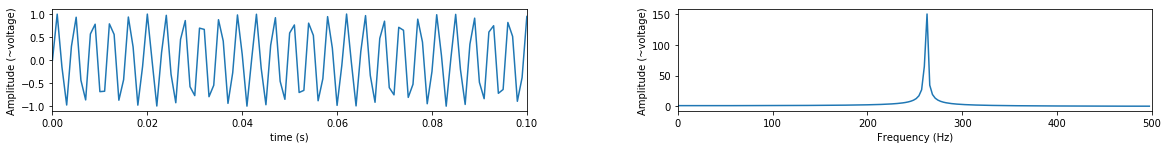

In [7]:
plot_signal(262)

Let's take it a step further and see how waveform and observed frequency vary over a larger range of frequencies.  We'll input the frequencies associated with 2 octaves of an E<sup>$\flat$</sup> major scale and plot each pitch.

With each pitch, frequency increases slightly and we'll expect to see that reflected in the waveform duration (shorter) and the observed frequencies (higher) from the fourier transform.

We'll also note that our frequencies range from 311 to 1245, a frequency band of 934 Hz.

*We add a short delay between each plot to make it easier to observe the progression.*

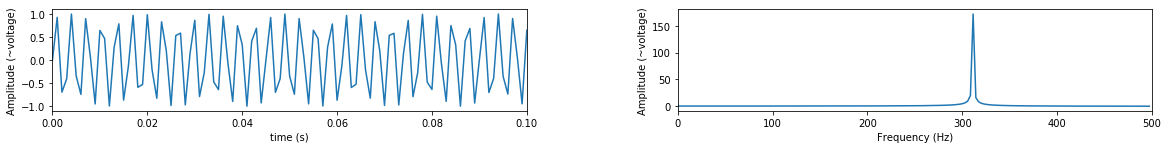

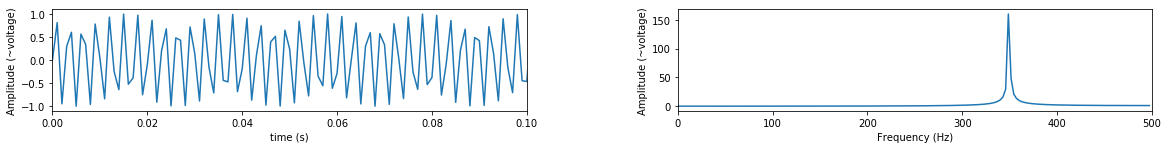

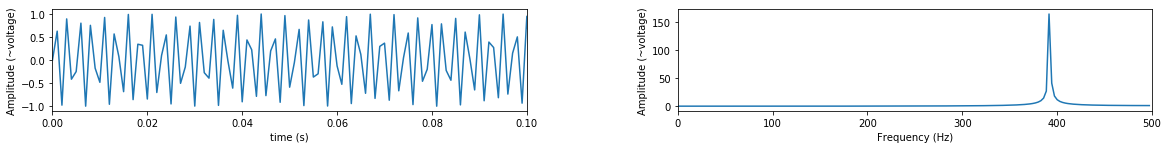

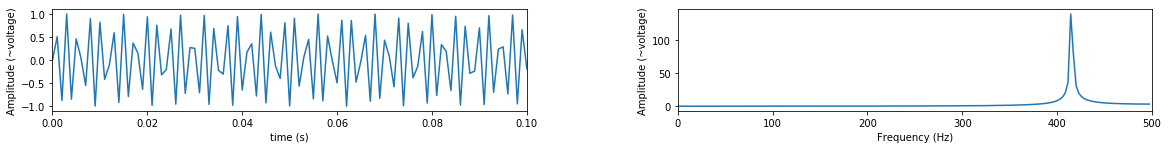

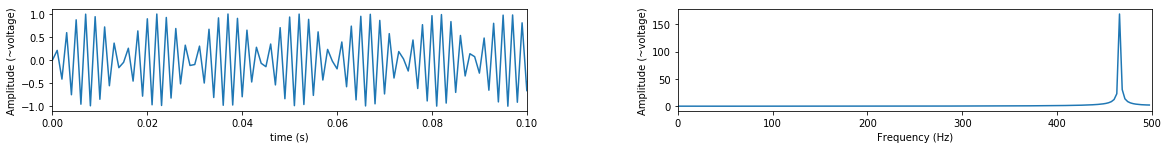

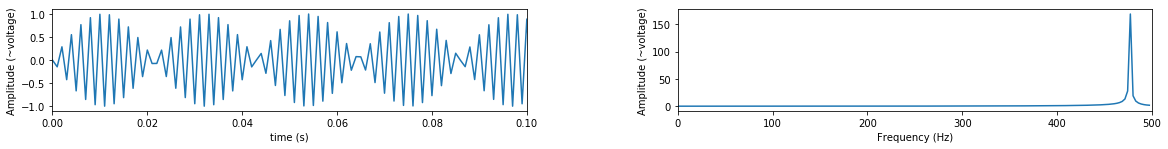

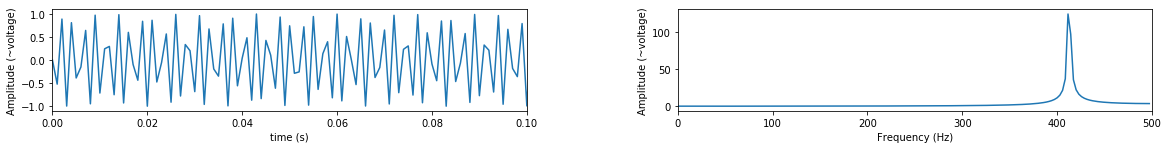

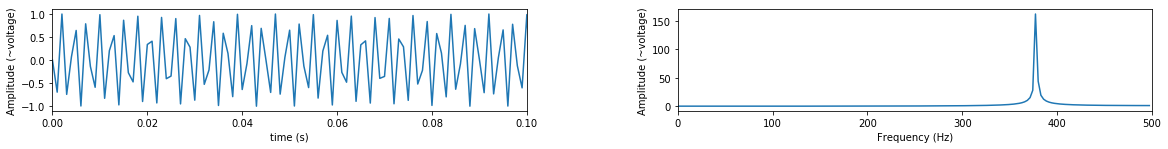

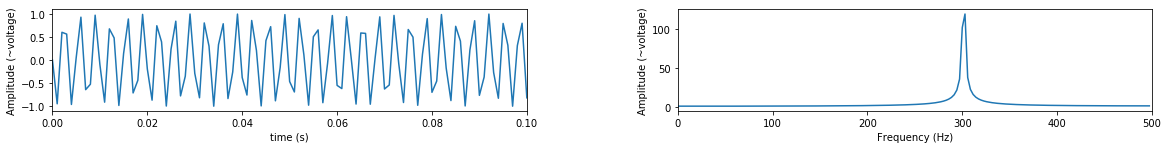

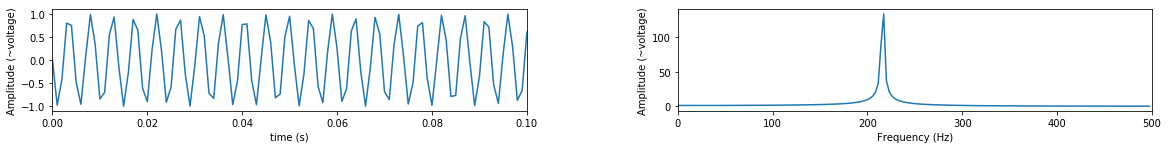

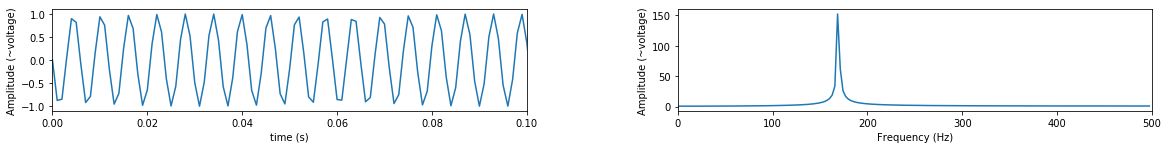

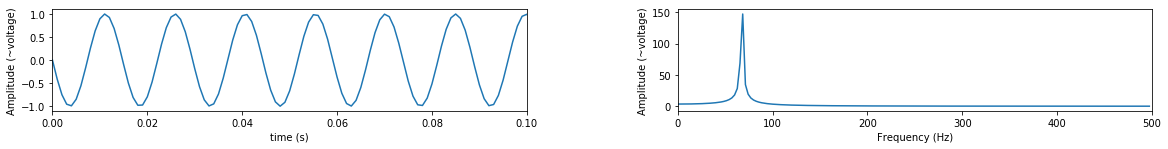

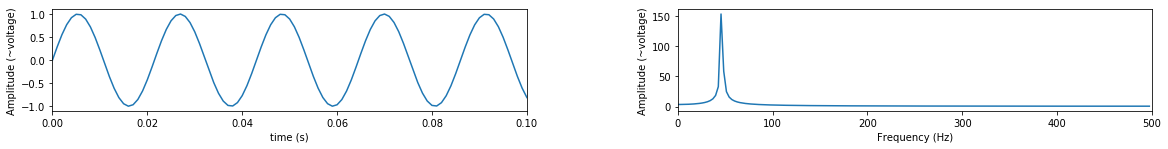

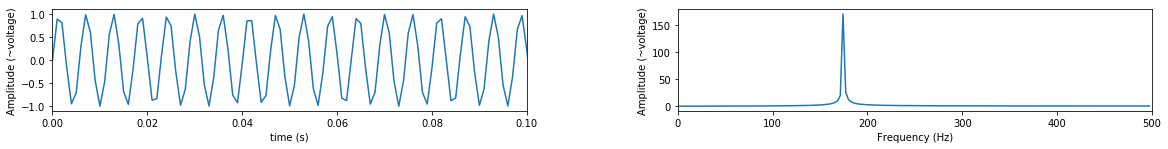

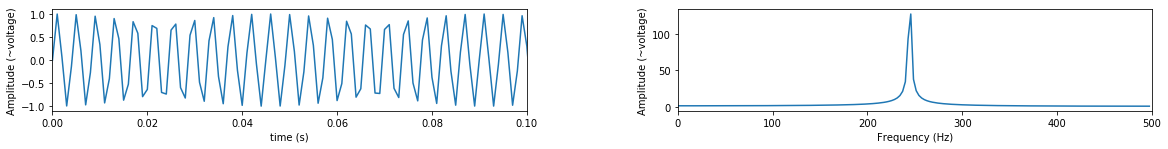

In [8]:
# two octaves of e-flat major scale
frequencies = [
    311.13, 349.23, 392, 415.3, 466.16, 523.25, 587.33, 
    622.25, 698.46, 783.99, 830.61, 932.33, 1046.5, 1174.66, 
    1244.51
    ]

# loop through scale and plot waveform & observed frequency of each note
for i in range(len(frequencies)):
    plot_signal(frequencies[i])
    plt.show()
    time.sleep(0.3)

## Aliasing

So what just happened?  Our frequencies seemed like they were increasing as we expected, but a few pitches in they started shrinking.  Then, at the tail end, they started increasing again.

This is known as **Aliasing** and it occurs when the sample rate is not at least 2x the frequency band.  In our case, we specified a sample rate of 1,000, but our frequency band was 934 Hz (with a max frequency of 1,245).

Given our sample rate, anything above 500 Hz is no longer being sampled quickly enough to accurately capture the signal.  The signal gets distorted and no longer match the original signal.

The bandwidth covered by sample rate is known as the Nyquist zone. In practice, ADCs (Analog Digital Converters) have properties that narrow their range of potential nyquist zones (up to 10 or so nyquist zones).

### Audible effect

We saw above how our digital readings suffered from aliasing and we'd expect that to make a difference audibly, too, when we play back our observed frequencies.

We have a general sense for what a concert scale sounds like; let's see our alias-distorted version sounds.

In [9]:
for i in range(len(frequencies)):
    x = tone(frequencies[i]) 
    sd.play(x, fs)
    sd.wait()

We hear the first few notes progress as expected, but then the entire scale goes out of wack.  So how can we fix this?

In this environment, where we control the inputs, we can easily increase the sample rate and that should solve our problem.  Our bandwidth of interest goes up to 1,245 so technically a sample rate of 2,500 should do the trick.

That said, it's good to have a bit of buffer as signals get a bit distorted as they approach the bounds of their Nyquist zone.  We'll increase the sample rate up to 5,000.

In [10]:
fs = 5000 # sample rate
duration = 0.35

And next let's recalculate the dependencies to make sure that change flows through.

In [11]:
# nbr of samples
N = int(duration * fs)

# step size
dt = 1 / fs
df = fs / N

# frequency & time vector
f_arr = np.linspace(-fs/2, fs/2 - df, N)
t = np.linspace(0, duration - dt, N)

And now let's take a listen to our scale.  Voila!  All two octaves sound just as we expected and we have solved our aliasing problem.

In [12]:
for i in range(len(frequencies)):
    x = tone(frequencies[i]) 
    sd.play(x, fs)
    sd.wait()

## Summary

Aliasing is the distortion of a recorded signal that occurs when the sample rate does not sufficiently cover the bandwidth of interest.

In our case, the aliasing was relatively simple to spot when it occurred because we knew exactly which frequencies were input and therefore what to expect in the output.  In real life scenarios, it may not be that straightforward.

If you don't have a sense of the signal, there won't necessarily be a glaring warning if or when alias occurs.  As we saw in our exercise, frequencies **were** recorded (the system didn't break or error) - just the wrong ones.

In practice, solving the problem of aliasing will usually be based on a known sampling rate and frequency rate.  In other words, there's an assumption that we have *some* knowledge of the incoming signal and can adjust accordingly from there.